In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pickle
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
from tqdm import tqdm
! pip install optuna
import optuna
!pip install fasttext
import fasttext

In [3]:
# !pip install torch torchvision torchaudio
# !pip install --upgrade torch torchvision torchaudio


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# task 1 , 2 , 3 (load)

In [5]:
train_data = pd.read_csv('train_split.csv')
val_data = pd.read_csv('val_split.csv')
# test_data = pd.read_csv('test_split.csv')

train_labels = train_data['label']
val_labels = val_data['label']
# test_labels = test_data['label']

In [6]:
# Combine train and validation data for fasttext training
combined_data = pd.concat([train_data, val_data])

# Combine train and validation sentences for fasttext training
combined_data_df = pd.concat([train_data, val_data], axis=0)
max_inp_len = max(combined_data_df['tweet'].apply(lambda x: len(x.split(" "))))

In [7]:
combined_data_df[["tweet"]].to_csv('combined_data.txt', header=False, index=False,  encoding='utf-8')

In [8]:
# Specify the path for the fasttext model
fasttext_model_path = 'fasttext_model.bin'

# Train the FastText model on the combined dataset
model = fasttext.train_unsupervised('combined_data.txt', model='skipgram')
model.save_model(fasttext_model_path)

In [9]:
# Specify the path for the fasttext model
fasttext_model_path = 'fasttext_model.bin'

fasttext_model = fasttext.load_model(fasttext_model_path)

In [10]:
import numpy as np

def create_embedding_matrix(sentences, model, max_inp_len):
    embedding_matrix = np.zeros((len(sentences), max_inp_len, model.get_dimension()))

    for i, sentence in enumerate(sentences):
        tokens = sentence.split()[:max_inp_len]
        for j, token in enumerate(tokens):
            embedding_matrix[i, j, :] = model.get_word_vector(token)

    print(embedding_matrix.shape)
    return embedding_matrix

In [11]:
max_inp_len = max(pd.concat([train_data, val_data], axis=0)['tweet'].apply(lambda x: len(x.split(" "))))
d = fasttext_model.get_dimension()
print(max_inp_len , d)

970 100


In [12]:

# Create embedding matrices for train, val, and test datasets
train_embedding_matrix = create_embedding_matrix(train_data['tweet'], fasttext_model, max_inp_len)
val_embedding_matrix = create_embedding_matrix(val_data['tweet'], fasttext_model, max_inp_len)
# test_embedding_matrix = create_embedding_matrix(test_data['tweet'], fasttext_model, max_inp_len)

(8480, 970, 100)
(1060, 970, 100)


In [13]:
train_labels.shape , train_embedding_matrix.shape

((8480,), (8480, 970, 100))

In [14]:
val_labels.shape , val_embedding_matrix.shape

((1060,), (1060, 970, 100))

# Task 4

In [15]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        # Convert sparse matrix to dense tensor
        self.x = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Add an extra dimension to represent channels (1 in this case)
        x_sample = self.x[idx]   # .unsqueeze(0)
        return x_sample, self.y[idx]

In [16]:
train_dataset = CustomDataset(train_embedding_matrix, train_labels)
eval_dataset = CustomDataset(val_embedding_matrix, val_labels)
# test_dataset = CustomDataset(test_embedding_matrix, test_labels)

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
eval_dataloader = DataLoader(eval_dataset, batch_size = 32, shuffle = False)
# test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [18]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([32, 970, 100]) torch.Size([32])


In [19]:
# train_loader = torch.utils.data.DataLoader(train_dataset,          # our raw data
#                                            batch_size=32,  # the size of batches we want the dataloader to return
#                                            shuffle=True,           # shuffle our data before batching
#                                            drop_last=False)        # don't drop the last batch even if it's smaller than batch_size
# imgs, targets = next(iter(train_loader))
# imgs.shape

## Basic Network

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [21]:
import torch.nn as nn

class LSTM0(nn.Module):
    def __init__(self, input_size, num_layers= 1, output_size =2):
        super(LSTM0, self).__init__()

        self.lstm = nn.LSTM(input_size, 256, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256 * 2, output_size)  # multiplied by 2 for bidirectional LSTM

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the output from the last time step
        x = self.fc(lstm_out)
        return x


In [22]:
import torch
network = LSTM0(input_size=d).to(device)

In [23]:
from torchsummary import summary
# Assuming your input data size is (970, 100)
# input_size = (100 ,) # (channels, width)

# # Print the model summary
# summary(network, input_size=d)

In [24]:
batch_x, batch_y = next(iter(train_dataloader))
print(batch_x.shape, batch_y.shape)

torch.Size([32, 970, 100]) torch.Size([32])


## Basic Training Loop

In [25]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(network.parameters(), lr = 0.001)
epochs = 10

In [26]:
train_epoch_loss = []
eval_epoch_loss = []

In [27]:
for epoch in tqdm(range(epochs)):
    curr_loss = 0
    total = 0
    for train_x, train_y in train_dataloader:

        train_x = train_x.to(device)
        train_y = train_y.to(device)
        optim.zero_grad()

        y_pred = network(train_x)
        loss = criterion(y_pred, train_y)

        loss.backward()
        optim.step()

        curr_loss += loss.item()
        total += len(train_y)
    train_epoch_loss.append(curr_loss / total)

    curr_loss = 0
    total = 0
    for eval_x, eval_y in eval_dataloader:
        eval_x = eval_x.to(device)
        eval_y = eval_y.to(device)
        optim.zero_grad()

        with torch.no_grad():
            y_pred = network(eval_x)

        loss = criterion(y_pred, eval_y)

        curr_loss += loss.item()
        total += len(train_y)
    eval_epoch_loss.append(curr_loss / total)


100%|██████████| 10/10 [03:21<00:00, 20.15s/it]


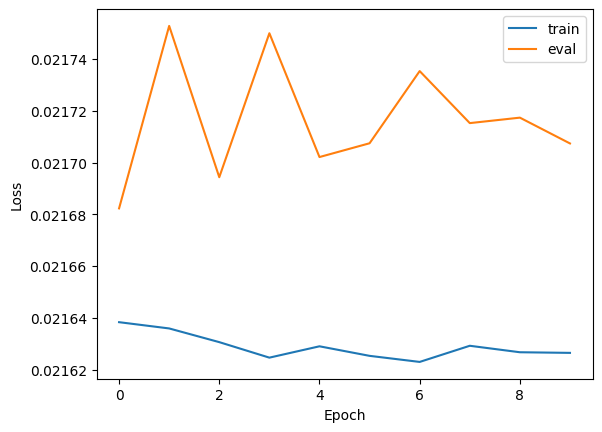

In [28]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_epoch_loss, label='train')
plt.plot(range(epochs), eval_epoch_loss, label='eval')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
correct = 0
total = 0
for x, y in eval_dataloader:
    x = x.to(device)
    with torch.no_grad():
        yp = network(x)
    yp = torch.argmax(yp.cpu(), dim = 1)
    correct += (yp == y).sum()
    total += len(y)
prev_eval_acc = correct / total
print(f"Accuracy on Eval Data {(prev_eval_acc * 100):.2f}")

Accuracy on Eval Data 50.00


In [30]:
prev_model = network

In [31]:
# save model
torch.save(prev_model.state_dict(), 'lstm_model_p.pth')

## now hyperparameter optimization

In [32]:
!pip install torchmetrics
from torchmetrics import Accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 10.2 MB/s eta 0:00:00


In [33]:
class LSTM2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim =2, num_layers=1, dropout=0.2, bidirectional=False):
        super(LSTM2, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, x):
        # x: [batch_size, seq_length, input_dim]

        # LSTM
        lstm_out, _ = self.lstm(x)

        # Extract the output of the last time step
        last_output = lstm_out[:, -1, :]

        # Fully connected layer
        out = self.fc(last_output)

        return out

In [34]:
def train_model(model, criterion, optimizer, dataloader, device):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Calculate accuracy
        y_pred = torch.argmax(outputs, dim = 1)
        correct_predictions += (y_pred == targets).sum().item()
        total_samples += len(targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    accuracy = correct_predictions / total_samples
    total_loss /= total_samples
    return total_loss, accuracy

In [35]:
def evaluate_model(network, criterion, eval_dataloader, device):
    network.eval()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for eval_x, eval_y in eval_dataloader:
            eval_x = eval_x.to(device)
            eval_y = eval_y.to(device)

            y_pred = network(eval_x)
            loss = criterion(y_pred, eval_y)

            total_loss += loss.item()

            # Calculate accuracy
            y_pred = torch.argmax(y_pred, dim = 1)
            correct_predictions += (y_pred == eval_y).sum().item()
            total_samples += len(eval_y)

    total_loss /= total_samples
    accuracy = correct_predictions / total_samples

    return total_loss, accuracy

In [36]:
import optuna
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.nn.init import xavier_uniform_, kaiming_normal_
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.nn import LeakyReLU, PReLU
from torch.utils.data import DataLoader
from torch.nn import L1Loss, MSELoss

def objective(trial):
    # Define hyperparameters to be optimized

    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.0, 0.4)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "PReLU"])
    epochs = trial.suggest_int("epochs", 10, 20)

    # Instantiate the model with the sampled hyperparameters
    network = LSTM2(d, hidden_dim, 2, num_layers, dropout, bidirectional)

    optimizer = torch.optim.Adam(network.parameters(), lr = 0.001)

    # input_size = (100, 970)  # (channels, width)

    # # Print the model summary
    # summary(network, input_size=input_size)

    # Move the model to the appropriate device
    network.to(device)
    best_eval_loss = float('inf')
    no_improvement = 0
    batch_size =32

    # Define DataLoader instances
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    # test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    for epoch in tqdm(range(epochs), desc="Epochs"):
        train_loss , train_acc = train_model(network, criterion, optimizer, train_dataloader, device)
        eval_loss, eval_acc = evaluate_model(network, criterion, eval_dataloader, device)

        # Report the validation loss to Optuna for optimization
        trial.report(eval_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    print(f"Training acc = {train_acc} , Val acc = {eval_acc}")
    return eval_acc  # eval_loss


In [37]:
# Create Optuna study and run optimization
study = optuna.create_study(direction="maximize")  # or "minimize" for a loss
study.optimize(objective, n_trials=10, timeout=5000)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-13 04:22:58,506] A new study created in memory with name: no-name-9860c18c-3d1d-476f-a2d8-dc64e1656622
Epochs: 100%|██████████| 20/20 [15:57<00:00, 47.87s/it]
[I 2024-03-13 04:38:55,953] Trial 0 finished with value: 0.5 and parameters: {'hidden_dim': 234, 'num_layers': 2, 'dropout': 0.06918043209522122, 'bidirectional': True, 'activation': 'ReLU', 'epochs': 20}. Best is trial 0 with value: 0.5.


Training acc = 0.5248820754716981 , Val acc = 0.5


Epochs: 100%|██████████| 10/10 [03:56<00:00, 23.64s/it]
[I 2024-03-13 04:42:52,406] Trial 1 finished with value: 0.5 and parameters: {'hidden_dim': 228, 'num_layers': 2, 'dropout': 0.32065140391714836, 'bidirectional': False, 'activation': 'PReLU', 'epochs': 10}. Best is trial 0 with value: 0.5.


Training acc = 0.5248820754716981 , Val acc = 0.5


Epochs: 100%|██████████| 11/11 [04:02<00:00, 22.01s/it]
[I 2024-03-13 04:46:54,557] Trial 2 finished with value: 0.5 and parameters: {'hidden_dim': 204, 'num_layers': 2, 'dropout': 0.10504357277908444, 'bidirectional': False, 'activation': 'PReLU', 'epochs': 11}. Best is trial 0 with value: 0.5.


Training acc = 0.5248820754716981 , Val acc = 0.5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.79s/it]
[I 2024-03-13 04:48:50,358] Trial 3 finished with value: 0.5 and parameters: {'hidden_dim': 65, 'num_layers': 3, 'dropout': 0.2939174247564136, 'bidirectional': False, 'activation': 'ReLU', 'epochs': 20}. Best is trial 0 with value: 0.5.


Training acc = 0.5248820754716981 , Val acc = 0.5


Epochs: 100%|██████████| 16/16 [08:15<00:00, 30.97s/it]
[I 2024-03-13 04:57:05,948] Trial 4 finished with value: 0.5 and parameters: {'hidden_dim': 135, 'num_layers': 2, 'dropout': 0.31572143020427823, 'bidirectional': False, 'activation': 'PReLU', 'epochs': 16}. Best is trial 0 with value: 0.5.


Training acc = 0.5248820754716981 , Val acc = 0.5


Epochs:   0%|          | 0/19 [01:19<?, ?it/s]
[I 2024-03-13 04:58:25,384] Trial 5 pruned. 
Epochs:   0%|          | 0/12 [00:31<?, ?it/s]
[I 2024-03-13 04:58:56,859] Trial 6 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.07627444926263408 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Epochs:   0%|          | 0/12 [00:25<?, ?it/s]
[I 2024-03-13 04:59:22,015] Trial 7 pruned. 
Epochs: 100%|██████████| 15/15 [01:10<00:00,  4.71s/it]
[I 2024-03-13 05:00:32,616] Trial 8 finished with value: 0.5 and parameters: {'hidden_dim': 81, 'num_layers': 2, 'dropout': 0.01048512073007455, 'bidirectional': False, 'activation': 'PReLU', 'epochs': 15}. Best is trial 0 with value: 0.5.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout 

Training acc = 0.5248820754716981 , Val acc = 0.5


Epochs:   0%|          | 0/11 [00:15<?, ?it/s]
[I 2024-03-13 05:00:48,320] Trial 9 pruned. 


Best trial:
  Value:  0.5
  Params: 
    hidden_dim: 234
    num_layers: 2
    dropout: 0.06918043209522122
    bidirectional: True
    activation: ReLU
    epochs: 20


In [41]:
train_epoch_loss = []
eval_epoch_loss = []

In [42]:
from torchsummary import summary
# Retrieve the best parameters
best_params = study.best_params
# example
# best_params = {'learning_rate': 0.007328217711618778, 'batch_size': 32, 'n_layers': 2, 'n_units': 64,
#                'dropout_prob': 0.0758288355159868, 'activation': 'PReLU', 'weight_init_method': 'xavier',
#                'optimizer': 'RMSprop', 'use_early_stopping': False, 'patience': 8, 'epochs': 19, 'cnn_kernel': 3,
#                'cnn_stride': 3, 'cnn_padding': 0, 'cnn_channel': 128}


# Create an instance of your Network
network2 = LSTM2(d, hidden_dim=best_params['hidden_dim'], output_dim =2, num_layers=best_params['num_layers'], dropout=best_params['dropout'], bidirectional=best_params['bidirectional'])

network2.to(device)
optimizer = torch.optim.Adam(network2.parameters(), lr = 0.001)

# # Learning rate scheduler
# if lr_schedule == "step_lr":
#     scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
# elif lr_schedule == "exp_lr":
#     scheduler = ExponentialLR(optimizer, gamma=0.9)

# Move the model to the appropriate device
# input_size = (100, 970)  # (channels, width)

# # Print the model summary
# summary(network2, input_size=input_size)


best_eval_loss = float('inf')
no_improvement = 0
batch_size = 32
epochs = best_params['epochs']

# Define DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
now_eval_acc = 0
for epoch in tqdm(range(epochs), desc="Epochs"):
    train_loss , train_acc = train_model(network2, criterion, optimizer, train_dataloader, device)
    eval_loss, eval_acc = evaluate_model(network2, criterion, eval_dataloader, device)

    train_epoch_loss.append(train_loss)
    eval_epoch_loss.append(eval_loss)
    now_eval_acc = eval_acc


Epochs: 100%|██████████| 20/20 [16:02<00:00, 48.12s/it]


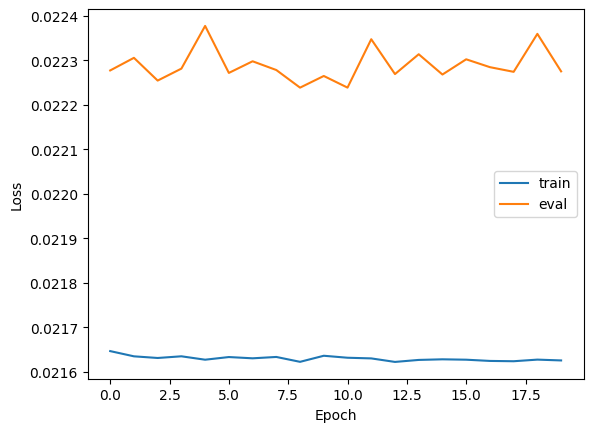

In [43]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_epoch_loss, label='train')
plt.plot(range(epochs), eval_epoch_loss, label='eval')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
test_loss, test_acc = evaluate_model(network2, criterion, eval_dataloader, device)
print(f"Accuracy on Eval Data {test_acc}")

Accuracy on Eval Data 0.5


In [52]:
# save model
filename = "lstm_model.pickle"

if prev_eval_acc > now_eval_acc:
  print("1")
  # pickle.dump(prev_model, open(filename, "wb"))
  torch.save(prev_model.state_dict(), 'Lstm_model.pth')
else:
  # pickle.dump(network2, open(filename, "wb"))
  torch.save(network2.state_dict(), 'Lstm_model.pth')

In [46]:
import json

# torch.save(network2.state_dict(), 'Dnn_model.pth')
# Assuming best_params is defined
with open('Lstm_best_params.json', 'w') as f:
    json.dump(best_params, f)

In [47]:
test_data = pd.read_csv('test_split.csv')
test_labels = test_data['label']
test_embedding_matrix = create_embedding_matrix(test_data['tweet'], fasttext_model, max_inp_len)
test_dataset = CustomDataset(test_embedding_matrix, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

(1060, 970, 100)


In [48]:
from sklearn.metrics import accuracy_score, classification_report

In [49]:
def get_classification_report(model, test_dataloader, device, model_file = "Cnn"):
    model.eval().to(device)
    y_true = []
    y_pred = []
    with torch.no_grad():
        for test_x, test_y in test_dataloader:
            test_x, test_y = test_x.to(device), test_y.to(device)

            if model_file == "Cnn":
                outputs = model(test_x.permute(0,2,1))
            else:
                outputs = model(test_x)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(test_y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_file} Accuracy: {accuracy:.4f}")

    # Calculate and print precision, recall, and f1-score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"{model_file} Precision: {precision:.4f}")
    print(f"{model_file} Recall: {recall:.4f}")
    print(f"{model_file} F1-Score: {f1:.4f}")

    # Print the classification report
    print(f"{model_file} Classification Report:")
    print(classification_report(y_true, y_pred))
    print("\n")

In [50]:
with open('Lstm_best_params.json', 'r') as f:
    best_params = json.load(f)

In [53]:
best_model = LSTM0(input_size=d)
best_model2 = LSTM2(d, hidden_dim=best_params['hidden_dim'], output_dim =2, num_layers=best_params['num_layers'], dropout=best_params['dropout'], bidirectional=best_params['bidirectional'])
try:
    best_model.load_state_dict(torch.load('Lstm_model.pth', map_location=torch.device(device)))
    get_classification_report(best_model, test_dataloader, device,"Lstm")
except:
    best_model2.load_state_dict(torch.load('Lstm_model.pth', map_location=torch.device(device)))
    report = get_classification_report(best_model2, test_dataloader, device,"Lstm")
    best_model = best_model2

Lstm Accuracy: 0.5321
Lstm Precision: 0.2831
Lstm Recall: 0.5321
Lstm F1-Score: 0.3696
Lstm Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       496
           1       0.53      1.00      0.69       564

    accuracy                           0.53      1060
   macro avg       0.27      0.50      0.35      1060
weighted avg       0.28      0.53      0.37      1060





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13